# Heart data classification with pytorch MLP

## Import

In [142]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
from copy import deepcopy
from collections import Counter, OrderedDict

import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.decomposition import PCA


## Hyper-parameters

In [118]:
# Batch size for training (change depending on how much memory you have)
batch_size = 241

# Number of epochs to train for
n_epochs = 5000

# # Gradient clipping(gradient threshold)
# max_norm = 1

# Data split ratio - train : validation : test = 8 : 1 : 1
tr_val_tt_ratio = {'tr': 0.8, 'val': 0.1, 'tt': 0.1}

# Learning rate
learning_rate = 0.01

# Learning device
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Load data, make datasets and dataloaders

In [119]:
# # # Check relative path
# # !chcp 65001
# # %ls

# # Load data from file
# raw_data = pd. read_csv(f'./heart.csv')

# # Seperate data and labels
# x_data = raw_data.iloc[:,:-1].to_numpy()
# y_data = raw_data['target'].to_numpy()
# # y_data = np.eye(np.unique(y_data, axis=0).shape[0])[y_data]  # one hot encoding

# # Split data into three parts (train, validation, and test) for each class of label
# x_tr_val, x_tt, y_tr_val, y_tt = train_test_split(x_data, y_data, test_size=0.1, shuffle=True, stratify=y_data)
# x_tr, x_val, y_tr, y_val = train_test_split(x_tr_val, y_tr_val, test_size=1/9, shuffle=True, stratify=y_tr_val)

# # Counter(y_tr), Counter(y_val), Counter(y_tt)

In [120]:
# # Check relative path
# !chcp 65001
# %ls

# Load data from file
raw_data = pd. read_csv(f'./heart.csv')

# Seperate data and labels
x_data = raw_data.iloc[:,:-1].to_numpy()
y_data = raw_data['target'].to_numpy()
# y_data = np.eye(np.unique(y_data, axis=0).shape[0])[y_data]  # one hot encoding

# Split data into three parts (train, validation, and test) for each class of label
x_tr_val, x_tt, y_tr_val, y_tt = train_test_split(x_data, y_data, test_size=0.1, shuffle=True, stratify=y_data)
x_tr, x_val, y_tr, y_val = train_test_split(x_tr_val, y_tr_val, test_size=1/9, shuffle=True, stratify=y_tr_val)

# Split data into three parts (train, validation, and test) for each class of label (PCA)
X_reduced = PCA(n_components=3).fit_transform(x_data)
x_tr_val_PCA, x_tt_PCA, y_tr_val_PCA, y_tt_PCA = train_test_split(X_reduced, y_data, test_size=0.1, shuffle=True, stratify=y_data)
x_tr_PCA, x_val_PCA, y_tr_PCA, y_val_PCA = train_test_split(x_tr_val_PCA, y_tr_val_PCA, test_size=1/9, shuffle=True, stratify=y_tr_val_PCA)

In [121]:
# Custom dataset class
class CustomDataset(Dataset): 
  def __init__(self, x_data, y_data):
    self.len = len(x_data)
    self.x_data = torch.FloatTensor(x_data)
    self.y_data = torch.LongTensor(y_data)

  def __len__(self):
    return self.len

  def __getitem__(self, idx):
    return self.x_data[idx], self.y_data[idx]

# Create datasets according to purpose
tr_set = CustomDataset(x_tr, y_tr)
val_set = CustomDataset(x_val, y_val)
tt_set = CustomDataset(x_tt, y_tt)

# Create dataloaders for each data set and declare them in the form of a dictionary.
dataloaders = {
                'tr': DataLoader(tr_set, batch_size=batch_size, shuffle=True,), 
                'val': DataLoader(val_set, batch_size=len(val_set)),
                'tt': DataLoader(tt_set, batch_size=len(tt_set)),
              }

# Create datasets according to purpose
tr_set_PCA = CustomDataset(x_tr_PCA, y_tr_PCA)
val_set_PCA = CustomDataset(x_val_PCA, y_val_PCA)
tt_set_PCA = CustomDataset(x_tt_PCA, y_tt_PCA)

# Create dataloaders for each data set and declare them in the form of a dictionary.
dataloaders_PCA = {
                'tr': DataLoader(tr_set_PCA, batch_size=batch_size, shuffle=True,),
                'val': DataLoader(val_set_PCA, batch_size=len(val_set_PCA)),
                'tt': DataLoader(tt_set_PCA, batch_size=len(tt_set_PCA)),
              }

## Model

In [207]:
# 3 linear layer MLP with ReLU
class CustomModel(nn.Module):
    def __init__(self, input_size, output_size) -> None:
        super(CustomModel, self).__init__()
        sigmoid = nn.Sigmoid()
        softmax = nn.Softmax(1)
        self.seq = nn.Sequential(
            nn.Linear(input_size, 8),
            sigmoid,
            nn.Linear(8, 4),
            sigmoid,
        )
        self.classifier = nn.Sequential(
            nn.Linear(4, output_size),
            softmax
        )

        # init parameters
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.seq(x)
        x = self.classifier(x)
        return x.squeeze()

def print_parameters(model_ft):
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name, param.shape)
    num_of_params = []
    for i in params_to_update:
        num_of_params.append(list(i.view(-1).shape).pop())
    print(f'num of params: {sum(num_of_params)}')
    # return params_to_update, num_of_params

model = CustomModel(13, 2).to(device)
model_PCA = CustomModel(3, 2).to(device)

# check model
print_parameters(model)
print_parameters(model_PCA)

	 seq.0.weight torch.Size([8, 13])
	 seq.0.bias torch.Size([8])
	 seq.2.weight torch.Size([4, 8])
	 seq.2.bias torch.Size([4])
	 classifier.0.weight torch.Size([2, 4])
	 classifier.0.bias torch.Size([2])
num of params: 158
	 seq.0.weight torch.Size([8, 3])
	 seq.0.bias torch.Size([8])
	 seq.2.weight torch.Size([4, 8])
	 seq.2.bias torch.Size([4])
	 classifier.0.weight torch.Size([2, 4])
	 classifier.0.bias torch.Size([2])
num of params: 78


In [123]:
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

since = time.time()

loss_history = {phase: list() for phase in ['tr', 'val']}

best_val_loss = torch.inf
best_model_wts = deepcopy(model.state_dict())

for epoch in range(n_epochs):
    print(f'\nEpoch {epoch} / {n_epochs-1}', end=' || ')

    # Each epoch has a training and validation phase
    for phase in ['tr', 'val']:
        if phase == 'tr': model.train()
        else: model.eval()

        running_loss = 0.0

        # Iterate over data
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'tr'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'tr':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        print(f'{phase} loss: {epoch_loss:.3f}', end=' || ')

        if phase == 'val' and epoch_loss < best_val_loss:
            best_val_loss = epoch_loss
            best_model_wts = deepcopy(model.state_dict())

        loss_history[f'{phase}'].append(epoch_loss)

time_elapsed = time.time() - since
print()
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
print(f'Best val loss: {best_val_loss:.3f}')

model.load_state_dict(best_model_wts)


Epoch 0 / 4999 || tr loss: 0.708 || val loss: 0.707 || 
Epoch 1 / 4999 || tr loss: 0.704 || val loss: 0.703 || 
Epoch 2 / 4999 || tr loss: 0.701 || val loss: 0.699 || 
...Epoch 4997 / 4999 || tr loss: 0.442 || val loss: 0.446 || 
Epoch 4998 / 4999 || tr loss: 0.442 || val loss: 0.448 || 
Epoch 4999 / 4999 || tr loss: 0.442 || val loss: 0.446 || 
Training complete in 0m 18s
Best val loss: 0.410


<All keys matched successfully>

In [124]:
optimizer = optim.Adam(model_PCA.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

since = time.time()

loss_history_PCA = {phase: list() for phase in ['tr', 'val']}

best_val_loss_PCA = torch.inf
best_model_wts_PCA = deepcopy(model_PCA.state_dict())

for epoch in range(n_epochs):
    print(f'\nEpoch {epoch} / {n_epochs-1}', end=' || ')

    # Each epoch has a training and validation phase
    for phase in ['tr', 'val']:
        if phase == 'tr': model_PCA.train()
        else: model_PCA.eval()

        running_loss = 0.0

        # Iterate over data
        for inputs, labels in dataloaders_PCA[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'tr'):
                outputs = model_PCA(inputs)
                loss = criterion(outputs, labels)

                if phase == 'tr':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataloaders_PCA[phase].dataset)
        print(f'{phase} loss: {epoch_loss:.3f}', end=' || ')

        if phase == 'val' and epoch_loss < best_val_loss_PCA:
            best_val_loss_PCA = epoch_loss
            best_model_wts_PCA = deepcopy(model_PCA.state_dict())

        loss_history_PCA[f'{phase}'].append(epoch_loss)

time_elapsed = time.time() - since
print()
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
print(f'Best val loss: {best_val_loss_PCA:.3f}')

model_PCA.load_state_dict(best_model_wts_PCA)


Epoch 0 / 4999 || tr loss: 0.696 || val loss: 0.685 || 
Epoch 1 / 4999 || tr loss: 0.693 || val loss: 0.682 || 
Epoch 2 / 4999 || tr loss: 0.690 || val loss: 0.679 || 
...Epoch 4997 / 4999 || tr loss: 0.520 || val loss: 0.663 || 
Epoch 4998 / 4999 || tr loss: 0.520 || val loss: 0.662 || 
Epoch 4999 / 4999 || tr loss: 0.520 || val loss: 0.662 || 
Training complete in 0m 17s
Best val loss: 0.611


<All keys matched successfully>

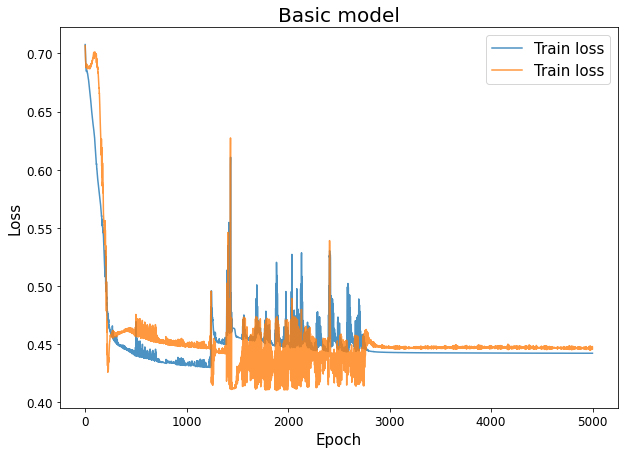

In [195]:
plt.figure(figsize=(10,7))
plt.plot(list(range(n_epochs)), loss_history['tr'], '', label = 'Train loss', alpha=0.8)
plt.plot(list(range(n_epochs)), loss_history['val'], '-', label = 'Train loss', alpha=0.8)
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.legend(fontsize=15)
plt.title('Basic model', fontsize = 20)
plt.show()

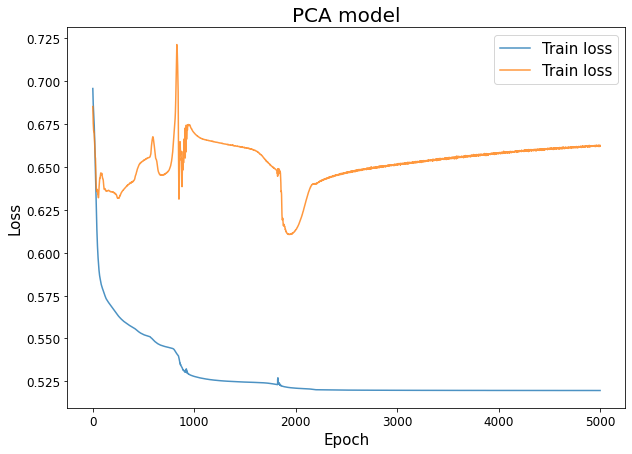

In [196]:
plt.figure(figsize=(10,7))
plt.plot(list(range(n_epochs)), loss_history_PCA['tr'], '', label = 'Train loss', alpha=0.8)
plt.plot(list(range(n_epochs)), loss_history_PCA['val'], '-', label = 'Train loss', alpha=0.8)
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.legend(fontsize=15)
plt.title('PCA model', fontsize = 20)
plt.show()

## Test

<Figure size 432x288 with 0 Axes>

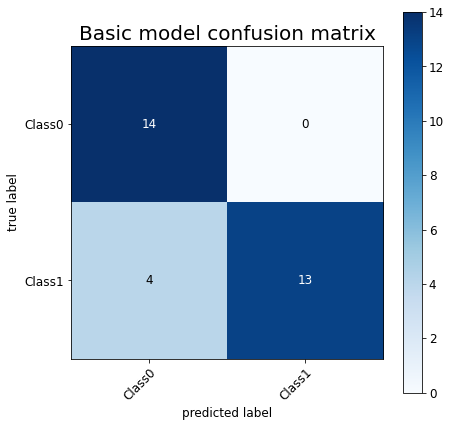

Accuracy: 87.10%


In [159]:
tt_x, tt_y = tt_set[:]
tt_x, tt_y = tt_x.to(device), tt_y.to(device)
tt_pred = torch.argmax(model(tt_x), dim = 1)
is_equal = torch.eq(tt_pred,tt_y)

confusion_matrix = np.zeros((2, 2))
label = [f'Class{i}' for i in range(2)]
for i in range(len(is_equal)):
    if is_equal[i]:
        confusion_matrix[tt_pred[i],tt_pred[i]] += 1
    else:
        confusion_matrix[tt_y[i],tt_pred[i]] += 1
confusion_matrix = confusion_matrix.astype(int)

plt.figure()
plt.rcParams.update({'font.size': 12})
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix,
                                figsize = (7,7),
                                class_names=label,
                                colorbar=True,
                                )
plt.title('Basic model confusion matrix', fontsize = 20)
plt.show()

print(f'Accuracy: {is_equal.sum().item()/len(is_equal)*100:.2f}%')

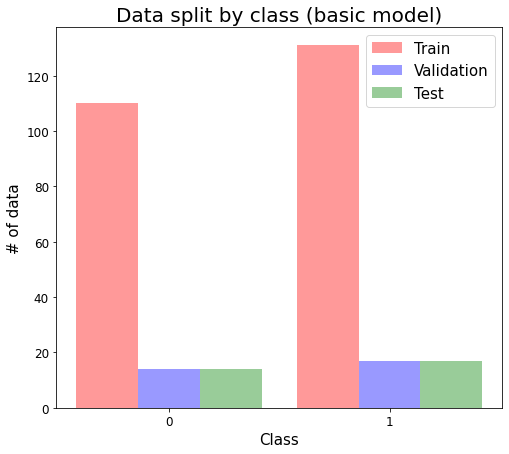

Basic train data {0: 110, 1: 131}
Basic validation data {0: 14, 1: 17}
Basic test data {0: 14, 1: 17}


In [209]:
tr_x, tr_y = tr_set[:]
val_x, val_y = val_set[:]
tt_x, tt_y = tt_set[:]

tr_counter = dict(sorted(Counter(tr_y.to('cpu').numpy()).items(), key = lambda x:x[0]))
val_counter = dict(sorted(Counter(val_y.to('cpu').numpy()).items(), key = lambda x:x[0]))
tt_counter = dict(sorted(Counter(tt_y.to('cpu').numpy()).items(), key = lambda x:x[0]))

bar_width = 0.28

plt.figure(figsize=(8,7))
plt.bar(np.array([0, 1])-bar_width, tr_counter.values(), label = 'Train', width=bar_width, alpha=0.4, color ='red')
plt.bar(np.array([0, 1]), val_counter.values(), label = 'Validation', width=bar_width, alpha=0.4, color ='blue')
plt.bar(np.array([0, 1])+bar_width, tt_counter.values(), label = 'Test', width=bar_width, alpha=0.4, color ='green')
plt.xticks([0, 1])
plt.xlabel('Class', fontsize = 15)
plt.ylabel('# of data', fontsize = 15)
plt.legend(fontsize=15)
plt.title('Data split by class (basic model)', fontsize = 20)
plt.show()
print(f'Basic train data {tr_counter}')
print(f'Basic validation data {val_counter}')
print(f'Basic test data {tt_counter}')

<Figure size 432x288 with 0 Axes>

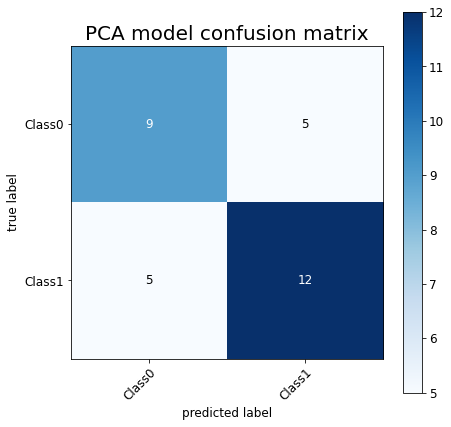

Accuracy: 67.74%


In [164]:
tt_x_PCA, tt_y_PCA = tt_set_PCA[:]
tt_x_PCA, tt_y_PCA = tt_x_PCA.to(device), tt_y_PCA.to(device)
tt_pred_PCA = torch.argmax(model_PCA(tt_x_PCA), dim = 1)
is_equal_PCA = torch.eq(tt_pred_PCA,tt_y_PCA)

confusion_matrix_PCA = np.zeros((2, 2))
label_PCA = [f'Class{i}' for i in range(2)]
for i in range(len(is_equal_PCA)):
    if is_equal_PCA[i]:
        confusion_matrix_PCA[tt_pred_PCA[i],tt_pred_PCA[i]] += 1
    else:
        confusion_matrix_PCA[tt_y_PCA[i],tt_pred_PCA[i]] += 1
confusion_matrix_PCA = confusion_matrix_PCA.astype(int)

plt.figure()
plt.rcParams.update({'font.size': 12})
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix_PCA,
                                figsize = (7,7),
                                class_names=label_PCA,
                                colorbar=True,
                                )
plt.title('PCA model confusion matrix', fontsize = 20)
plt.show()

print(f'Accuracy: {is_equal_PCA.sum().item()/len(is_equal_PCA)*100:.2f}%')

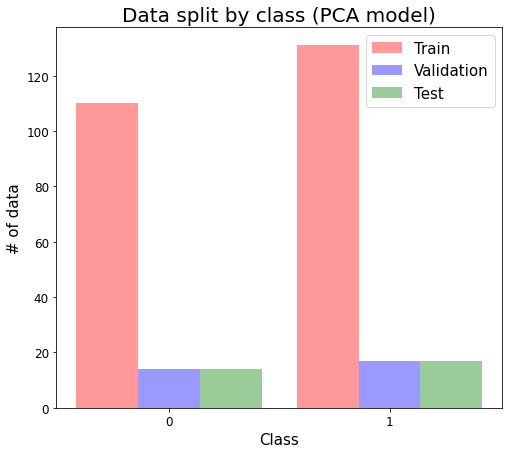

PCA train data {0: 110, 1: 131}
PCA validation data {0: 14, 1: 17}
PCA test data {0: 14, 1: 17}


In [208]:
tr_x_PCA, tr_y_PCA = tr_set_PCA[:]
val_x_PCA, val_y_PCA = val_set_PCA[:]
tt_x_PCA, tt_y_PCA = tt_set_PCA[:]

tr_counter_PCA = dict(sorted(Counter(tr_y_PCA.to('cpu').numpy()).items(), key = lambda x:x[0]))
val_counter_PCA = dict(sorted(Counter(val_y_PCA.to('cpu').numpy()).items(), key = lambda x:x[0]))
tt_counter_PCA = dict(sorted(Counter(tt_y_PCA.to('cpu').numpy()).items(), key = lambda x:x[0]))

bar_width = 0.28

plt.figure(figsize=(8,7))
plt.bar(np.array([0, 1])-bar_width, tr_counter_PCA.values(), label = 'Train', width=bar_width, alpha=0.4, color ='red')
plt.bar(np.array([0, 1]), val_counter_PCA.values(), label = 'Validation', width=bar_width, alpha=0.4, color ='blue')
plt.bar(np.array([0, 1])+bar_width, tt_counter_PCA.values(), label = 'Test', width=bar_width, alpha=0.4, color ='green')
plt.xticks([0, 1])
plt.xlabel('Class', fontsize = 15)
plt.ylabel('# of data', fontsize = 15)
plt.legend(fontsize=15)
plt.title('Data split by class (PCA model)', fontsize = 20)
plt.show()
print(f'PCA train data {tr_counter_PCA}')
print(f'PCA validation data {val_counter_PCA}')
print(f'PCA test data {tt_counter_PCA}')